$$\newcommand{\Xb}{\boldsymbol{X}}
\newcommand{\yb}{\boldsymbol{y}}
\newcommand{\wb}{\boldsymbol{w}}
$$

These examples use my favorite deep learning software:

* [PyTorch], developed by Facebook.


I like to use PyTorch with [Skorch] (which provides a Scikit-Learn API to PyTorch).

[PyTorch]:https://pytorch.org/
[Skorch]:https://skorch.readthedocs.io/en/stable/

# Overfitting

**Key messages:**

* Training loss and testing loss are ***very* different.**

Higher model complexity → lower training loss, higher testing loss.

* **Regularization** can circumvent overfitting (but requires problem-specific knowledge).

This notebook will provide a clear example of overfitting the training data, and regularization will be a way to circumvent that issue.

# Setup

Let's start with a simple system: one that tries to fit a polynomial to some data:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

In [3]:
def polynomial(x, d=3):
    return -x**3 + x**2 + x

<AxesSubplot:xlabel='x'>

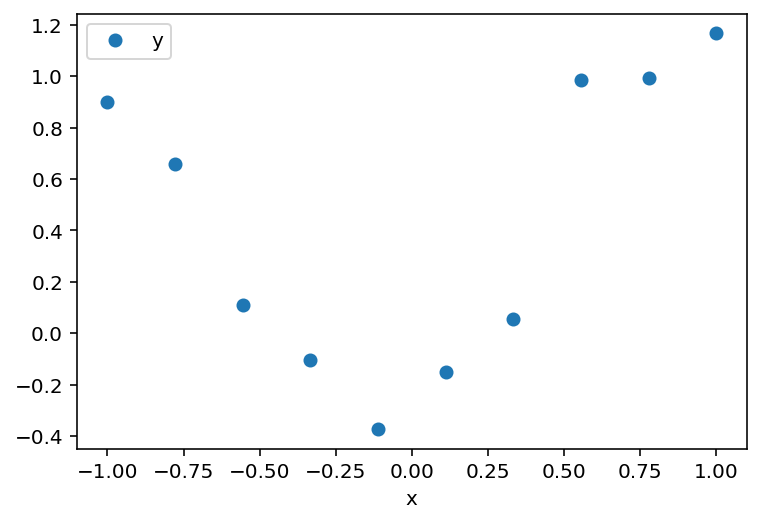

In [4]:
x = np.linspace(-1, 1, num=10)
y = polynomial(x)
eps = 0.4
noise = np.random.RandomState(42).uniform(-eps, eps, size=x.size)
y += noise
y = y.astype("float32")

df = pd.DataFrame({"x": x, "y": y})
df.plot(x="x", y="y", style="o")

# Basics

Let's create a model to fit this data with a degree $d$ polynomial:

In [5]:
import torch
import torch.nn as nn

In [6]:
class Polynomial(nn.Module):
    def __init__(self, d=3):
        super().__init__()
        self.d = d
        self.weights = nn.Linear(d + 1, 1, bias=False)
        
    def forward(self, x):
        inputs = [x**i for i in range(self.d + 1)]
        inputs = torch.cat(inputs, axis=1)
        return self.weights(inputs)

This model performs this function:

$$y = w_0 + w_1x + w_2x^2 + \cdots + w_dx^d$$

In [7]:
poly = Polynomial()
_input = x[0].reshape(-1, 1).astype("float32")
poly(torch.from_numpy(_input))

tensor([[0.5700]], grad_fn=<MmBackward>)

Now let's optimize this model:

In [8]:
from skorch import NeuralNet
from utils import Optimizer

est = Optimizer(
    module=Polynomial,
    module__d=3,  # 3rd degree polynomial
    criterion=nn.MSELoss,
    max_epochs=1000,
)
X = x.reshape(-1, 1).astype("float32")

In [9]:
est.fit(X, y.reshape(-1, 1))

<class 'skorch.net.NeuralNet'>[initialized](
  module_=Polynomial(
    (weights): Linear(in_features=4, out_features=1, bias=False)
  ),
)

This is computing $w_3x^3 + w_2x^2 + w_1x^1 + w_0$ for all of our test data:

Let's see how well this did:

In [10]:
x_ = np.linspace(-1.5, 1.5).reshape(-1, 1).astype("float32")
y_pred = est.predict(x_)

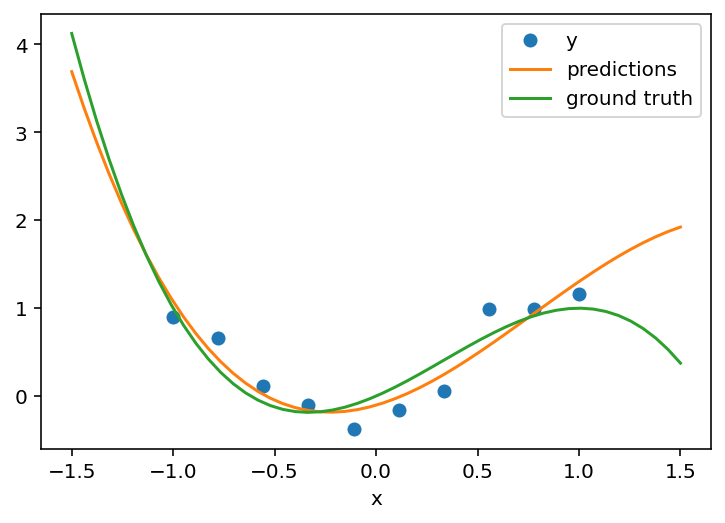

In [11]:
ax = df.plot(x="x", y="y", style="o")
ax.plot(x_, y_pred, label="predictions")
ax.plot(x_, polynomial(x_), label="ground truth")
ax.legend(loc="best")

Not too shabby.

The true weights:

``` python
true_weights = [-1, 1, 1, 0]
```

In [12]:
est.module_.weights.weight

Parameter containing:
tensor([[-0.1034,  0.6741,  1.2934, -0.5615]], requires_grad=True)

Not the best, but not unreasonable (all weights between -2 and 2).

# Overfitting

But what if our model is more complex?

In [13]:
est = Optimizer(
    module=Polynomial,
    module__d=12,
    criterion=nn.MSELoss,
    max_epochs=2000,
    verbose=False,
).initialize()
X = x.reshape(-1, 1).astype("float32")
print("Number of model parameters =", sum(x.nelement() for x in est.module_.parameters()))
print("Number of training examples =", x.size)

Number of model parameters = 13
Number of training examples = 10


In [14]:
est.fit(X, y.reshape(-1, 1))

<class 'skorch.net.NeuralNet'>[initialized](
  module_=Polynomial(
    (weights): Linear(in_features=13, out_features=1, bias=False)
  ),
)

Our model is fitting the training data better, but performing a lot worse on generalization – **how good will the prediction be for a *new* datum?**

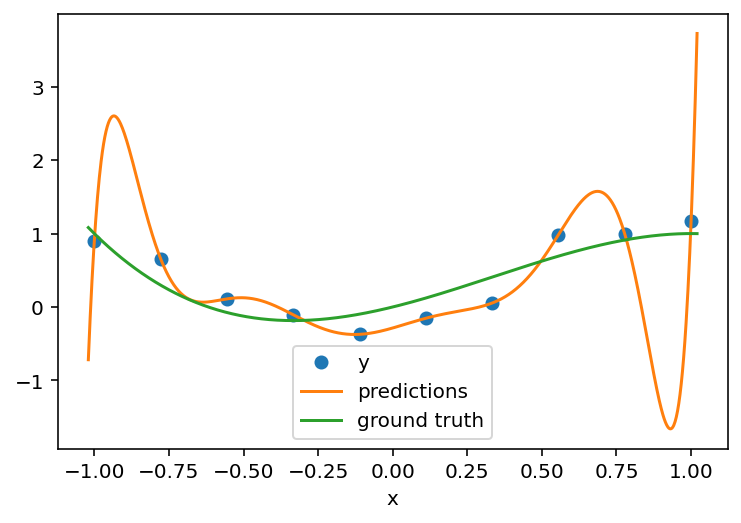

In [15]:
x_ = np.linspace(-1.02, 1.02, num=1000).reshape(-1, 1).astype("float32")
y_pred = est.predict(x_)
ax = df.plot(x="x", y="y", style="o")
ax.plot(x_, y_pred, label="predictions")
ax.plot(x_, polynomial(x_), label="ground truth")
ax.legend(loc="best")

In addition, our weights are large:

In [16]:
est.module_.weights.weight

Parameter containing:
tensor([[ -0.2860,   1.1662,   1.8064, -15.4629,   5.7030,  73.9424,  -7.5839,
         -84.6051,  -5.6804, -37.0333,   0.7784,  62.1260,   6.2956]],
       requires_grad=True)

This problem is not unique to polynomials. It also applies to these cases:

* More features than samples with a linear model?
* Using a "deep neural network"?

**There may be no way around this.** For example, what if you have genomic data (and 5,000 weights in your linear model) but only 500 examples because each genomic test is very expensive?

So how you work around overfitting?

# Regularization

Above, we minimized a loss function $L$ that depended on a model $\wb$:

$$\arg\min_{\wb} L(\wb)$$

Now, let's minimize a loss function $L$ *and* some penalty on model complexity $R$:

$$\arg\min_{\wb} L(\wb) + \lambda R(\wb)$$

$\lambda$, a scalar, will control the balance between the loss and regularizer $R$. If $\lambda = \infty$, then the simplest model is produced. If $\lambda = 0$, the loss function is minimized.

Let's set the regularization to be

$$R(\wb) = w_0^2 + w_1^2 + \cdots + w_d^2 = \|\wb\|_2^2$$

aka "ridge regression." Let's perform that regularization:

In [17]:
# This is probably easiest:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

With PyTorch/Skorch, not much modification is required:

In [18]:
from sklearn.base import clone
from skorch import NeuralNet

class Regularized(NeuralNet):
    def get_loss(self, *args, **kwargs):
        loss = super().get_loss(*args, **kwargs)
        
        lamduh = 8e-2
        
        _abs = [w.abs().sum() for w in self.module_.parameters()]
        n_params = sum([w.nelement() for w in self.module_.parameters()])

        norm = sum(_abs) / n_params
        return loss + lamduh * norm

Great – let's see how well this performs:

In [19]:
import torch.optim as optim

est2 = Regularized(
    module=Polynomial,
    module__d=12,
    criterion=nn.MSELoss,
    verbose=False,
    batch_size=-1,
    max_epochs=1000,
    optimizer=optim.LBFGS,
)
est2.fit(X, y.reshape(-1, 1))

<class '__main__.Regularized'>[initialized](
  module_=Polynomial(
    (weights): Linear(in_features=13, out_features=1, bias=False)
  ),
)

Let's look at the predictions:

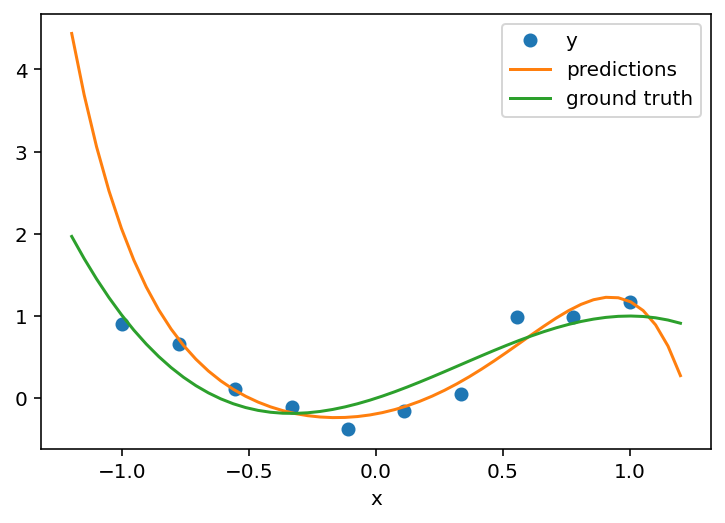

In [20]:
x_ = np.linspace(-1.2, 1.2).reshape(-1, 1).astype("float32")
y_pred = est2.predict(x_)
ax = df.plot(x="x", y="y", style="o")
ax.plot(x_, y_pred, label="predictions")
ax.plot(x_, polynomial(x_), label="ground truth")
ax.legend(loc="best")

We are performing a regularization on the weights. It encourages small weights:

<AxesSubplot:>

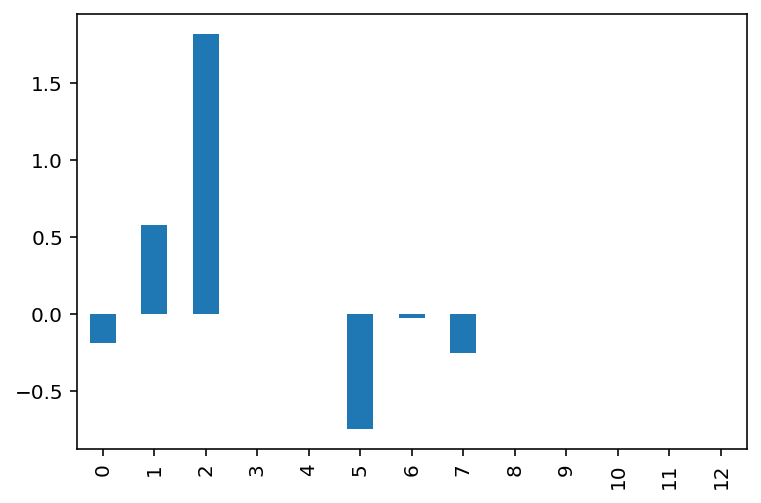

In [21]:
w =  est2.module_.weights.weight
import pandas as pd
pd.Series(w.detach().numpy().flatten()).plot.bar()

# Other regularization

It's easy to do $\ell_2$ regularization aka "ridge regression" aka "Tikhonov regularization":

In [22]:
class RidgeRegression(NeuralNet):
    def __init__(self, *args, lamduh=0.1, **kwargs):
        self.lamduh = lamduh
        super().__init__(*args, **kwargs)
        
    def get_loss(self, *args, **kwargs):
        loss = super().get_loss(*args, **kwargs)
        
        _norms = [torch.norm(w, p=2)**2 for w in self.module_.parameters()]
        n_params = sum([w.nelement() for w in self.module_.parameters()])
        norm = sum(_norms) / n_params

        return loss + self.lamduh * norm
        

This relies on a special optimization technique called "[automatic differentation][1]." If we wanted to, we could generalize this to *any* norm:

[1]:https://en.wikipedia.org/wiki/Automatic_differentiation

In [23]:
class LpRegularization(NeuralNet):
    def __init__(self, *args, p=2, lamduh=0.1, **kwargs):
        self.lamduh = lamduh
        self.p = p
        super().__init__(*args, **kwargs)
        
    def get_loss(self, *args, **kwargs):
        loss = super().get_loss(*args, **kwargs)
        
        _norms = [torch.norm(w, p=self.p)**self.p for w in self.module_.parameters()]
        n_params = sum([w.nelement() for w in self.module_.parameters()])
        norm = sum(_norms) / n_params

        return loss + self.lamduh * norm
        
class LASSO(LpRegularization):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs, p=1)
    
class RidgeRegression(LpRegularization):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs, p=2)
        
static = dict(module=nn.Linear, criterion=nn.MSELoss)
r = RidgeRegression(lamduh=0.1, **static)
l = LASSO(lamduh=0.1, **static)